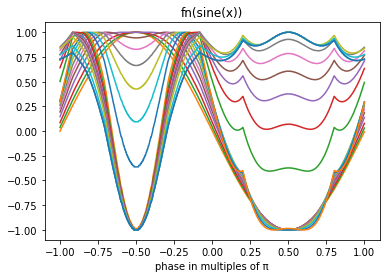

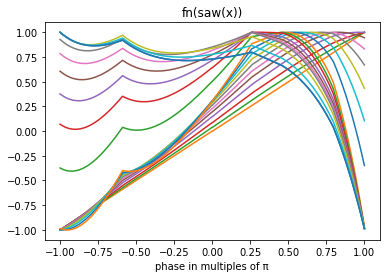

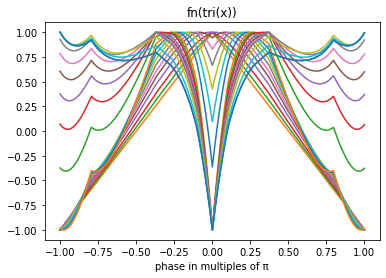

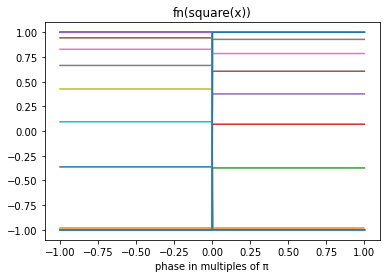

In [67]:
from matplotlib import pyplot as plt
import numpy as np
import random
import pyaudio
import math
import struct
from scipy.signal import sawtooth, square

#CHANGEME

coefficient_range = [-10,10] #range of polynomial coefficients, too large might cause clicks
poly_degree = 4 #max degree of polynomials, too large might cause clicks

pieces = 5  #number of different polynomials to stitch together

sequence_length = 20  #Length of function sequence. 0 means identity function only. 
                      #Graphs will be plotted for sequence_length < 10 only.

plotrange = 1000

#INITIALISE


#GENERATE CANDIDATE FUNCTIONS

poly_intervals = np.sort(np.append(np.random.uniform(low=-1.0, high=1.0, size=pieces-1),[-1,1])) #the piecewise interval points

random_coefficients = np.zeros((pieces, poly_degree+1, sequence_length+1))

for i in range(pieces):
    random_coefficients[i,poly_degree-1,0] = 1

random_coefficients[:,:,sequence_length] = np.random.uniform(low=coefficient_range[0], high=coefficient_range[1], size=(pieces,poly_degree+1)) #random matrix to draw polynomials from
                
for i in range(1,pieces):
    test = np.polyval(random_coefficients[i-1,:,sequence_length],poly_intervals[i]) - np.polyval(random_coefficients[i,:,sequence_length],poly_intervals[i])
    random_coefficients[i,poly_degree,sequence_length] += test
    #glues next piece continuously onto previous piece

###NORMALISE FINAL CURVE 
    
maximum = np.polyval(random_coefficients[0,:,sequence_length],-1)
minimum = maximum

for sample_in in np.linspace(-1, 1, num=10000): 
    for i in range(pieces):
        if sample_in < poly_intervals[i+1] and sample_in >= poly_intervals[i]: 
            region = i
    maximum = max(np.polyval(random_coefficients[region,:,sequence_length],sample_in), maximum)
    minimum = min(np.polyval(random_coefficients[region,:,sequence_length],sample_in), minimum)

for i in range(pieces):
    random_coefficients[i,poly_degree,sequence_length] -= minimum
    random_coefficients[i,:,sequence_length] = (random_coefficients[i,:,sequence_length]) * 2 / (maximum - minimum)
    random_coefficients[i,poly_degree,sequence_length] -= 1
        
###END NORMALISE FINAL CURVE   
    
for interp in range(1,sequence_length):
        for i in range(pieces):
            for j in range(poly_degree+1):
                random_coefficients[i,j,interp] = (random_coefficients[i,j,sequence_length] - random_coefficients[i,j,0]) * interp / sequence_length + random_coefficients[i,j,0]

                
#### NORMALISE INTERPOLATED CURVES
for interp in range(1,sequence_length):  
    maximum = np.polyval(random_coefficients[0,:,interp], -1)
    minimum = maximum
    for sample_in in np.linspace(-1, 1, num=10000): 
        for i in range(pieces):
            if sample_in < poly_intervals[i+1] and sample_in >= poly_intervals[i]: 
                region = i
        maximum = max(np.polyval(random_coefficients[region,:,interp],sample_in), maximum)
        minimum = min(np.polyval(random_coefficients[region,:,interp],sample_in), minimum)

    for i in range(pieces):
        random_coefficients[i,poly_degree,interp] -= minimum
        random_coefficients[i,:,interp] = (random_coefficients[i,:,interp])*2/(maximum - minimum)
        random_coefficients[i,poly_degree,interp] -= 1                

#### NORMALISE INTERPOLATED CURVES
    
    
region = 0

curves = np.zeros((sequence_length,plotrange))

curves[sequence_length-1,0] = np.polyval(random_coefficients[0,:,sequence_length-1],-1)

A = np.linspace(-1, 1, num=plotrange)

for seq in range(sequence_length):
    for sample_in in range(plotrange): 
        for i in range(pieces):
            if A[sample_in] < poly_intervals[i+1] and A[sample_in] >= poly_intervals[i]: 
                region = i
        curves[seq,sample_in] = np.polyval(random_coefficients[region,:,seq],A[sample_in])



# plt.figure(interp)

# for i in range(sequence_length):    
#         plt.plot(A,curves[i,:])

                                                    
def caller(x, interp):
    called_val = np.where(A == x)[0][0] #Returns the position of the input amplitude in the amplitude array A
    return(curves[interp,called_val])        #Outputs desired value f(x)

#PLOT AUDIO

def find_nearest(array, value):                #Allows any input to be rounded to the chosen bitrate, corresponding to a value in A
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

   
def plotter(type):
    waveplot = np.zeros(plotrange)
    for interp in range(sequence_length+1):
        
        if type == "sine":
            for i in range(plotrange):
                theta = 2 * math.pi * i/plotrange
                waveplot[i] = caller(find_nearest(A, math.sin(theta)),interp-1)                                                

        if type == "saw":
            for i in range(plotrange):
                theta = 2 * math.pi * i/plotrange
                waveplot[i] = caller(find_nearest(A, sawtooth(theta)),interp-1)

        if type == "tri":
            for i in range(plotrange):
                theta = 2 * math.pi * i/plotrange
                waveplot[i] = caller(find_nearest(A, sawtooth(theta, width = 0.5)),interp-1)
         
        if type == "square":
            for i in range(plotrange):
                theta = 2 * math.pi * i/plotrange
                waveplot[i] = caller(find_nearest(A, square(theta)),interp-1)   

        plt.plot(A, waveplot)
        plt.title("fn(" + type + "(x))")
        plt.xlabel("phase in multiples of π")
              
                
# #PLOT

# #     period_scale = sequence_length//2 #how many quarter-cycles to show. 4 = a single full cycle.

# #     axes = np.arange(0,2,1/period_scale/round(plotbuf.size/frequency))

#     plt.figure(sequence_length+2)    #plots all sine waves on single graph
#     plt.plot(axes,waveplot[0:period_scale*2*round(plotbuf.size/frequency)])
                                                  
# plt.title("fn(" + waveform + "(x))")
# plt.xlabel("phase in multiples of π")

plt.figure(0)
plotter("sine")

plt.figure(1)
plotter("saw")

plt.figure(2)
plotter("tri")

plt.figure(3)
plotter("square")
